In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.helpers import trace_helpers as th
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-11-25 17:34:43,016][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-11-25 17:34:43,061][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### some functions used here (will be hidden later)

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures


# Figure Style settings for notebook.

import matplotlib as mpl

plot_params = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    # 'font.sans-serif': 'Helvetica Neue',
    'font.size': 16,
    'lines.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.edgecolor': 'black',  
    # 'legend.frameon': False,
    'figure.subplot.wspace': .5,
    'figure.subplot.hspace': .5,
    # 'figure.figsize': (18, 13),
    'ytick.major.left': True,
    'xtick.major.bottom': True
}

map_params = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    # 'font.sans-serif': 'Helvetica Neue',
    'font.size': 12,
    'lines.color': 'black',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',  
    # 'legend.frameon': False,
    'figure.subplot.wspace': .5,
    'figure.subplot.hspace': .5,
    # 'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
}


img_params = {
    'axes.titlecolor': 'white',
    'axes.facecolor': 'black',
    'figure.facecolor': 'black',
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
}


# Recordings and example analysis for BonnBrain - RUKHMANI

In [3]:
# # LEON - example scans

# # Spontaneous activity	LE_ROS-1571_2023-07-20_scan9FJ5KHBX_sessFJ5KHBX			
# # Appearing Checkerboard Noise	LE_ROS-1571_2023-07-20_scan9FJ5L18B_sessFJ5L18B			
# # Moving Checkerboard Noise	LE_ROS-1571_2023-07-20_scan9FJ5L9VD_sessFJ5L9VD			
# # Moving Bars	LE_ROS-1571_2023-07-20_scan9FJ5LHYE_sessFJ5LHYE			
# # Moving Gratings	LE_ROS-1571_2023-07-20_scan9FJ5LVCL_sessFJ5LVCL			
# # Full Field Chirp	LE_ROS-1571_2023-07-20_scan9FJ5LZ1C_sessFJ5LZ1C			
# # Natural Movies	LE_ROS-1571_2023-07-20_scan9FJ5MGQ9_sessFJ5MGQ9			
# # VR Corridor	LE_ROS-1571_2023-07-20_scan9FJ5MPW6_sessFJ5MPW6			
# # Size Tuning	LE_ROS-1571_2023-07-20_scan9FJ5MVC0_sessFJ5MVC0			
# scan9FI8DYIV
# scan9FJ5LZ1C

# Bench2p figures and examples

In [9]:
# first define a key to be used across multiple tables

scansi = "scan9FKMRSOL"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
session_key = (session.Session & scan_key).fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch('KEY')[0]
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
print(aux_setup_typestr)
print((scan.ScanPath & scan_key).fetch("path")[0])

bench2p
/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL


In [ ]:
(imaging.Curation & scan_key & 'curation_id=1').fetch('KEY')

### Get and show overview images from suite2p registration

In [ ]:
ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

#### samesite parsing example

In [9]:

samesite_id = 'sess9FK61CPU'
samesite_session_key = (session.Session * session.SessionSameSite & f'same_site_id = "{samesite_id}"').fetch('KEY')
samesite_scan_key = (scan.Scan & samesite_session_key).fetch('KEY')


In [10]:
ref_samesite_image = (imaging.MotionCorrection.Summary & samesite_scan_key & 'field_idx=0').fetch('ref_image')
average_samesite_image = (imaging.MotionCorrection.Summary & samesite_scan_key & 'field_idx=0').fetch('average_image')
correlation_samesite_image = (imaging.MotionCorrection.Summary & samesite_scan_key & 'field_idx=0').fetch('correlation_image')
max_proj_samesite_image = (imaging.MotionCorrection.Summary & samesite_scan_key & 'field_idx=0').fetch('max_proj_image')

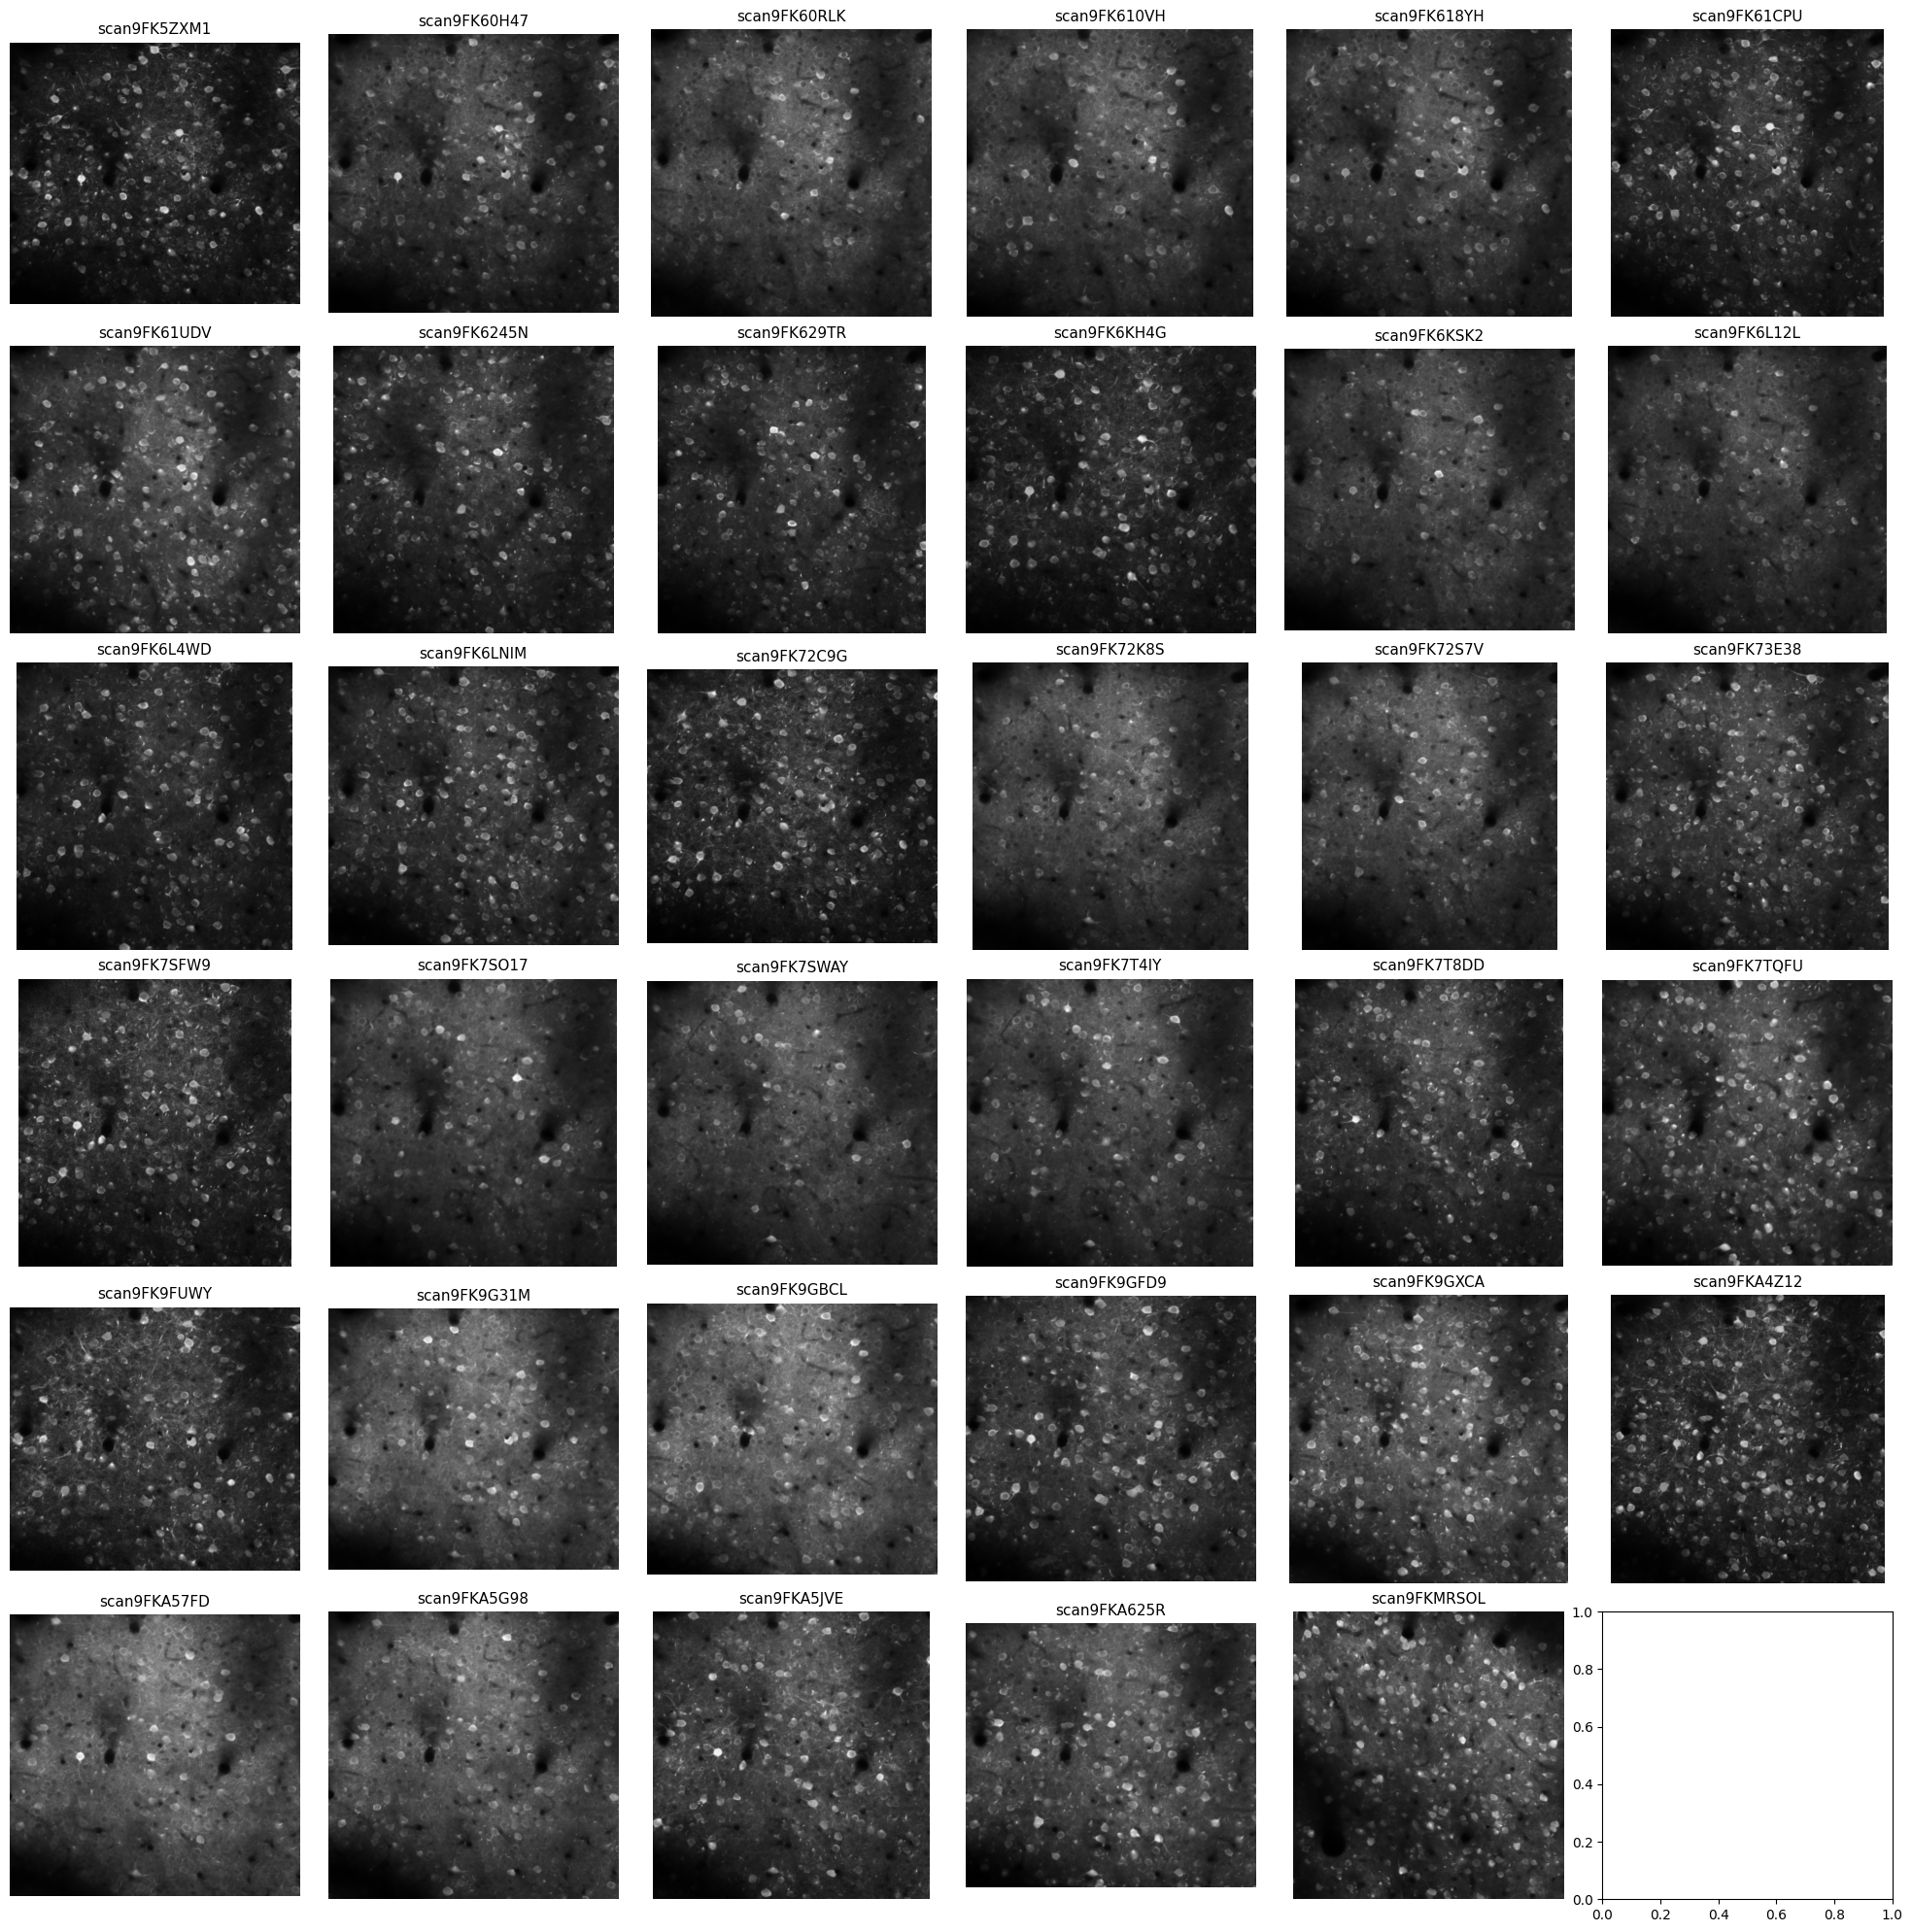

In [34]:
import matplotlib.pyplot as plt
import numpy as np

image = max_proj_samesite_image

# Extract scan_ids from the list of dictionaries
scan_ids = [d['scan_id'] for d in samesite_scan_key]

# Determine the grid size
grid_size = int(np.ceil(np.sqrt(len(image))))

# Create a larger figure and a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(25, 25))

# Flatten the axes array if there's more than one subplot
if grid_size > 1:
    axs = axs.flatten()

# Iterate over the images and scan_ids
for ax, image, scan_id in zip(axs, image, scan_ids):
    # Display the image and set the title with smaller font
    ax.imshow(image, cmap='gray')
    ax.set_title(scan_id, fontsize=11)
    ax.axis('off')  # Remove axes and axes labels

# Remove unused subplots
for ax in axs[len(image):]:
    ax.remove()

# Increase distance between plots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Display the figure
plt.show()

In [ ]:
# get some scaling values from pixel distribution
scalemin = 0
scalemax = 100

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

# Make figure with all templates
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
plt.suptitle(scansi)
# plt.savefig

In [ ]:
# just mean image
scalemin = 0
scalemax = 100

cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax)


# plt.subplot(1, 4, 1)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.show()


### Plot treadmill data

In [ ]:
# extract scan treadmill data from database using the scan_key from above
treadmill = (behavior.TreadmillRecording.Channel() & scan_key).fetch("data")[0]
auxtime = (behavior.TreadmillRecording.Channel() & scan_key).fetch("time")[0]

In [ ]:
# smoothing window size (ms)
window = 5000

# convert voltage to degree
treadmillnorm = (treadmill-np.min(treadmill)) / np.max(treadmill) * 360

# compute running speed (see function above)
angular_velocity_smoothed, unwrapped_angle_smoothed = ibe.compute_angular_velocity(auxtime, treadmillnorm, window)

# get some values to scale running speed plot 
scalemin = 0
scalemax = 100
offset = 10
ymin = np.percentile(angular_velocity_smoothed,scalemin)  - offset
ymax = np.percentile(angular_velocity_smoothed,scalemax)  + offset

# load plot styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende

# Plotting the time series
axes[0].plot(auxtime, treadmillnorm)
axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("Wheel position \n[degree]")
axes[0].set_xlabel("Time [s]")

axes[1].plot(auxtime[:-window+1],unwrapped_angle_smoothed )
# axes[1].set_ylim([-10000, 10000])
axes[1].set_ylabel("Unwrapped wheel position \n[cumulative degree]")
axes[1].set_xlabel("Time [s]")

axes[2].plot(auxtime[:-window],angular_velocity_smoothed)
axes[2].set_ylim([ymin, ymax])
axes[2].set_ylabel("Running speed \n[degree / s]")
axes[2].set_xlabel("Time [s]")

fig.suptitle(scan_key["scan_id"], fontsize=16)

plt.show() 

### Get the fluorescence traces of this recording

In [ ]:
# get mask positions of masks that are classified as cells and that are larger than a certain pixel size
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & scan_key
    & "mask_npix > 30"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [ ]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

In [ ]:
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.contour(mask_image, colors="red", linewidths=0.5)
plt.show()

In [ ]:
import matplotlib.colors as mcolors

# Normalize the average_image to [0, 1]
average_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Determine the number of masks
num_masks = len(mask_xpix)

# Generate random colormap using HSV
np.random.seed(42)  # For reproducibility, remove this line for truly random colors every time
hues = np.random.rand(num_masks)
colors = [mcolors.hsv_to_rgb([hue, 1, 1]) for hue in hues]

# # Create a color overlay using a perceptually uniform colormap
# colormap = plt.cm.viridis  # You can also use 'plasma', 'cividis', etc.
# colors = [colormap(i) for i in np.linspace(0, 1, num_masks)]


# Start with the grayscale image as the base
color_overlay = np.repeat(average_image[..., np.newaxis], 3, axis=2)

# Define an alpha factor for overall translucency (e.g., 0.5 for 50% transparency)
alpha_factor = 0.18

# Loop through masks, add color overlays
for (xpix, ypix), color in zip(zip(mask_xpix, mask_ypix), colors):
    for i in range(3):  # R, G, B channels
        color_overlay[ypix, xpix, i] = color_overlay[ypix, xpix, i] * (1 - alpha_factor) + color[i] * alpha_factor

# Display using Matplotlib
plt.imshow(color_overlay)
plt.show()


One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [ ]:
curation_key = (imaging.Curation & scan_key & curation_key).fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 5"
).proj()

# query_cells

In [ ]:
neuropilcorr = True

fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

neuropil_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "neuropil_fluorescence", order_by="mask"
)

if neuropilcorr:
    print("DOING VANILLA NEUROPIL CORRECTION NOW!")
    fluorescence_traces = fluorescence_traces - 0.7 * neuropil_traces

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

# timebase_2p = np.r_[: fluorescence_traces[0].size] * 1 / sampling_rate

timebase_2p = np.linspace(0, fluorescence_traces[0].size / sampling_rate, fluorescence_traces[0].shape[0])


In [ ]:
from rastermap import Rastermap
from scipy import stats 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d



# stack fluorescence for rastermap
# fluos = np.vstack(fluorescence_traces)
fluos = np.vstack(activity_traces)

nan_mask = np.isnan(fluos).any(axis=1)

# Create a mask for rows containing only zeros
zero_rows = np.all(fluos == 0, axis=1)

# Create a mask for rows containing only inf
inf_rows = np.all(np.isinf(fluos), axis=1)

# Create a mask for rows containing only NaN
nan_rows = np.all(np.isnan(fluos), axis=1)

# Combine the masks using logical OR
mask_to_remove = zero_rows | inf_rows | nan_rows | nan_mask

S = fluos[~mask_to_remove]
S = zscore(S, axis=1)

rmmodel = Rastermap(n_clusters=199, # None turns off clustering and sorts single neurons 
                  n_PCs=100, # use fewer PCs than neurons
                  locality=0.15, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(S)


y = rmmodel.embedding # neurons x 1
isort = rmmodel.isort

# sort by embedding and smooth over neurons (uncomment)

# Sfilt = gaussian_filter1d(S[isort], np.minimum(1,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
Sfilt = S[isort]

Sfilt_backup = Sfilt

In [ ]:
# Plot sorted data
# load plot styles for display

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

plt.figure(figsize=(50,15))
plt.imshow(Sfilt, vmin = -0.5, vmax=2, extent= [timebase_2p[0], timebase_2p[-1], 0, Sfilt.shape[0]], aspect='auto', cmap='gray_r')
plt.xlabel('time [s]')
plt.ylabel('sorted neurons')
plt.show()

Different visualization


In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(15,15))
ax = figure.add_subplot(111)

offset_scaler = 10 # We want to plot every cell with a little offset to the last one
for no,trace in enumerate(Sfilt):
    if no == 100: break # not more than 80

    # get the neuropil corrected values for that trace:
    # trace = Sfilt
    ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='k',alpha=.8)

ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted z-scored traces')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()

In [ ]:
import seaborn as sns
from scipy.ndimage import binary_dilation


method = "tank"
# method = "sd"
# method = "poor"

cutoff_std = float(3)
min_transient_length = .3

filtered_event_mask = []

for cell in range(len(activity_traces)):  
    # Horst's event filtering 
    re = th.FilterEvents(activity_traces[cell])
    if method == "tank":
        transient_dict = re.transients(fluorescence_traces[cell],
                    np.ones_like(fluorescence_traces[cell], dtype=bool),
                    sampling_rate, cutoff_std, min_transient_length, plot=False)
    elif method == "sd":
        transient_dict = re.robust(cutoff_std)  
    filtered_event_mask.append(transient_dict['mask_events'])

event_matrix = np.array(filtered_event_mask)


if method == "poor":
    event_matrix = np.array([item > cutoff_std for item in Sfilt], dtype=bool).astype(int)


# broaden events to generate non-event baseline for SNR calculation and second pass event detection with proper f0 baseline

cutoff_std = float(2)
min_transient_length = .250 # s

broaden_by = 1 # s

# Structuring element for one-second dilation
structure = np.ones(int(broaden_by * sampling_rate))

filtered_event_mask_2ndpass =[]
broadened_events = []
filtered_events = []
SNR = []
dFF0_traces = []

if method == "tank":
    for cell in range(len(activity_traces)):
        re = th.FilterEvents(activity_traces[cell])
        
        # make dF/F0 from first pass events
        F0mean = np.mean(fluorescence_traces[cell][np.logical_not(event_matrix[cell])])
        dFF0 = (fluorescence_traces[cell] - F0mean) / F0mean
        
        # Apply binary dilation on previous events and invert to get baseline
        
        broadened_events = binary_dilation(filtered_event_mask[cell], structure=structure) 
        
        transient_dict = re.transients(dFF0,
                    np.logical_not(broadened_events),
                    sampling_rate, cutoff_std, min_transient_length, plot=False)
 
        filtered_event_mask_2ndpass.append(transient_dict['mask_events'])
        filtered_events.append(transient_dict['filtered_events'])      
        
        SNR.append(np.mean(filtered_events[cell] / np.nanstd(dFF0[np.logical_not(broadened_events)])))
        dFF0_traces.append(dFF0)
        
    event_matrix_2ndpass = np.array(filtered_event_mask_2ndpass)



# sort events based on previous rastermap embedding
event_matrix = event_matrix[isort]
event_matrix_2ndpass = event_matrix_2ndpass[isort]
dFF0_traces = np.array(dFF0_traces)[isort]


# plot events and non-event epochs (with traces)

figure = plt.figure(figsize=(15,20))
ax = figure.add_subplot(111)


offset_scaler = 1.5 # We want to plot every cell with a little offset to the last one
for no, (trace, trace2) in enumerate(zip(event_matrix, event_matrix_2ndpass)):
    if no == 80: break # not more than 80

    ax.plot(timebase_2p, trace + (no * offset_scaler), lw=1, c='k', alpha=.8)
    ax.plot(timebase_2p, trace2 + (no * offset_scaler), lw=2, c='r', alpha=.8)


ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted binarized deconvolved traces')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()


#set used event_matrix
event_matrix = event_matrix_2ndpass
event_matrix_backup = event_matrix
SNR_matrix = np.array(SNR)[isort]

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(50,15))
ax = figure.add_subplot(111)

# SNRthresh = 3.5
SNRthresh = 100
offset_scaler = 5 # We want to plot every cell with a little offset to the last one
for no, (trace,evnts) in enumerate(zip(dFF0_traces[SNR_matrix > SNRthresh,:], event_matrix[SNR_matrix > SNRthresh,:] * 1)):
    if no == 30: break # not more than 25

    # get the neuropil corrected values for that trace:
    # trace = Sfilt
    ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='k',alpha=.8)
    ax.plot(timebase_2p, evnts + (no*offset_scaler - 1.4),lw=2,c='r',alpha=.8)

ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted, SNR-filtered dF/F0 traces')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()




#### Synchronization!

In [ ]:
# and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='bench2p_frames'" &  scan_key ).fetch('event_start_time')
aligned_wheel_indices = get_closest_timestamps(twoptimestamps,auxtime[:-window]) #smoothing windwo from above

# use this to index into the wheelspeed
angular_velocity_smoothed_2pref = angular_velocity_smoothed[aligned_wheel_indices]

# both arrays have same shape now - now 2pdata and wheel speed can be plotted together on the 2ptimestamps
print(np.shape(twoptimestamps))
print(np.shape(angular_velocity_smoothed_2pref))


In [ ]:
# limit data to SNR threshold from hereon
SNRthresh = 5

Sfilt = Sfilt_backup[SNR_matrix > SNRthresh]
# event_matrix = event_matrix_backup[SNR_matrix > SNRthresh]

In [ ]:
kp_colors = np.array([[0.55,0.55,0.55]])


# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] - 10

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(30,5), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[:2, :-1])
ax.plot(angular_velocity_smoothed_2pref,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# plot superneuron activity
ax = plt.subplot(grid[2:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.1, vmax=0.7,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted neurons")

plt.show()

# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")

## Stimulus Processing

In [ ]:
# These are all the stimulus events taht have the word "Grating in them"

event.Event() & scan_key & "event_type LIKE '%;%%'"



#### generate event trace

In [ ]:
# lets first generate a binary trace of grating event on- and offsets. 

# generate event trace for light stim

# from the event table get the grating
grating_timestamp_end = (event.Event()  &  "event_type LIKE '%grating%'" &  scan_key ).fetch('event_end_time', order_by = 'event_end_time')
grating_timestamp_start = (event.Event()  &  "event_type LIKE '%grating%'" &  scan_key ).fetch('event_start_time', order_by = 'event_start_time')
twoptimestamps = (event.Event()  &  "event_type='bench2p_frames'" &  scan_key ).fetch('event_start_time')



# get indices
aligned_grating_timestamp_end  = get_closest_timestamps(grating_timestamp_end, twoptimestamps) #smoothing windwo from above
aligned_grating_timestamp_start  = get_closest_timestamps(grating_timestamp_start, twoptimestamps) #smoothing windwo from above

# Create a linear array of zeros of length 10
array_length = np.shape(twoptimestamps)[0]
grating_array = np.zeros(array_length)

# Iterate through the start and stop times and set the corresponding elements to 1
for start, stop in zip(aligned_grating_timestamp_start, aligned_grating_timestamp_end):
    grating_array[start:stop] = .8
       
# alternatively (or in addition) we could also directly plot the stim-voltage trace by loading the data from the aux-file (I did not yet put that into the database - but will)
# check notebook 6 if you would like to plot aux_data


In [ ]:
# get stimulus sequence into an array

stimlist = (trial.TrialEvent() & scan_key).fetch("event_type", order_by = "event_start_time")
labels = ["Type", "Class", "Azimuth",  "Elevation", "Size", "Orientation", "SpatialFrequency", "TemporalFrequency"]
# labeled_list = [{label: value for label, value in zip(labels, string.split(';'))} for string in stimlist]
labeled_stim_list = [{label: int(value) if value.isdigit() else value for label, value in zip(labels, string.split(';'))} for string in stimlist]
orientation_sequence = [item['Orientation'] for item in labeled_stim_list]

In [ ]:
# For CHIRPS directly load aux file
from element_interface.utils import find_full_path
from adamacs.paths import get_experiment_root_data_dir
from pywavesurfer import ws

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
auxpath = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*h5"))

print(auxpath)
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
aux_setup_typestr
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )
sweep = [x for x in curr_file.keys() if 'sweep' in x][0]

In [ ]:
analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_labels = curr_file['header']['DIChannelNames']
sr = curr_file['header']['AcquisitionSampleRate'][0][0]

# Synch of aux
auxtime = np.linspace(0, len(analog_scans[0]) - 1, len(analog_scans[0]), dtype=int) / sr
aligned_aux_timestamps  = get_closest_timestamps(twoptimestamps,auxtime) #

chirptrace = analog_scans[0][aligned_aux_timestamps]

# digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], np.shape(digital_labels)[0])

In [ ]:
# make a figure with the speed data, stim data and sorted neurons

from matplotlib.ticker import MaxNLocator

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

# get some scaling values from pixel distribution
# SPEED 
scalemin = 0
scalemax = 99.7

cmin = np.percentile(angular_velocity_smoothed_2pref,scalemin)  
cmax = np.percentile(angular_velocity_smoothed_2pref,scalemax)

# Stim 
stim_cmin = 0
stim_cmax = 10


kp_colors = np.array([[0,0,0], [0.55,0.55,0.55], [0,0.9,0.9]])

imu_colors = np.array([
    [[1.0, 0.75, 0.8], [0.8, 0.65, 0.68], [0.55, 0.55, 0.55]],
    [[0.95, 0.6, 0.95], [0.75, 0.58, 0.75], [0.55, 0.55, 0.55]],
    [[0.65, 0.95, 0.95], [0.6, 0.75, 0.75], [0.55, 0.55, 0.55]]
])

# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] -1

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(20,10), dpi = 200)
grid = plt.GridSpec(12, 20, figure=fig, wspace = 0.5, hspace = 0.3)

# plot running speeda
ax = plt.subplot(grid[:2, :-1])
ax.plot(angular_velocity_smoothed_2pref,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([cmin, cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("treadmill\nspeed")
ax.yaxis.set_label_position("left")

# ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# plot stimtrace
ax = plt.subplot(grid[2:4, :-1])
ax.plot(chirptrace,  color=kp_colors[1])
ax.set_xlim([0, xmax-xmin])
# ax.set_ylim([stim_cmin, stim_cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
#put ori text on axis

# textyarray =  np.ones_like(aligned_grating_timestamp_start, dtype=float)-.15
# textyarray[1::2] += 0.11

# for x_text, y_text, text in zip(aligned_grating_timestamp_start, textyarray, orientation_sequence):
#     ax.text(x_text + 30, y_text, text, fontsize=8, ha='center', va='bottom')

ax.set_ylabel("grating stimulus")
ax.yaxis.set_label_position("left")

# plot neuronal activity
ax = plt.subplot(grid[4:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.3, vmax=2,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted cells")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")

# ---------- OLD # Mini2p figures and examples

In [ ]:
# first define a key to be used across multiple tables

scansi = "scan9FI8ALGO"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
print(aux_setup_typestr)
print((scan.ScanPath & scan_key).fetch("path")[0])

In [ ]:
imaging.Curation & scan_key 

### Get and show overview images from suite2p registration

In [ ]:
ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

In [ ]:
# get some scaling values from pixel distribution
scalemin = 0
scalemax = 100
offset = 0


cmin = np.percentile(average_image,scalemin)  
cmax = np.percentile(average_image,scalemax) + offset

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

# Make figure with all templates
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
# plt.savefig

In [ ]:
# just mean image
scalemin = 5
scalemax = 100

cmin = np.percentile(average_image,scalemin) 
cmax = np.percentile(average_image,scalemax) #+ offset


# plt.subplot(1, 4, 1)
plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.show()


### make cam-synchronized movie

In [ ]:
from pathlib import Path
import skvideo.io

# get the movie file name from the database
topfile = (model.VideoRecording.File & scan_key).fetch('file_path')[0]

#load to array
videodata = skvideo.io.vread(str(topfile))
# videodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in videodata], dtype=np.uint8)

#### make DLC overlay video

In [ ]:
# DEEPLABCUT OVERLAY - CURRENTLY ONLY WORKING IN MY ENVIRONMENT. NEED TO CHECK VERSIONS

# key = (model.VideoRecording & scan_key).fetch1('KEY')
# key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})


# from deeplabcut.utils.make_labeled_video import create_labeled_video
# import yaml
# from element_interface.utils import find_full_path
# from adamacs.paths import get_dlc_root_data_dir


# destfolder = model.PoseEstimationTask.infer_output_dir(scan_key)

# config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
#     list(
#         find_full_path(
#             get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
#         ).glob("*.y*ml")
#     )
# )

# create_labeled_video( # Pass strings to label the video
#     config=str(config_paths[-1]),
#     videos=str(topfile),
#     destfolder=str(destfolder),
# )

labeled_videofile = '/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/device_mini2p1_top_recording_scan9FHELAYA_model_Head_orientation-NK/scan9FHELAYA_top_video_2023-04-05T15_19_53DLC_resnet50_Head_orientationJul17shuffle1_90000_labeled.mp4'

labeled_videodata = skvideo.io.vread(str(labeled_videofile))


#### load moving average registered Ca2+ imaging movie

In [ ]:
from pathlib import Path
import skvideo.io
scandir = (scan.ScanPath & scan_key).fetch('path')[0]

directory = Path(scandir + "/suite2p/plane0/reg_tif")
pattern = '*20_frame*.mp4'
files = list(directory.glob(pattern))
print(files)

In [ ]:
# get the registered moving average (blinking) movie data of the specified scanID

scandir = (scan.ScanPath & scan_key).fetch('path')[0]

directory = Path(scandir + "/suite2p/plane0/reg_tif")
pattern = '*20_frame*.mp4'
files = list(directory.glob(pattern))
blinkvideodata = skvideo.io.vread(str(files[0]))
blinkvideodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in blinkvideodata], dtype=np.uint8)



In [ ]:
# display camaravideo with slider
sh.display_volume_z(videodata,1)

In [ ]:
# display 2pstackvideo with slider
sh.display_volume_z(blinkvideodata,1)

In [ ]:
# display 2pstackvideo with slider
sh.display_volume_z(labeled_videodata,1)

In [ ]:
#dimensionts of the original movie (frames, x,y,rgb)
print(videodata.shape)
print(blinkvideodata.shape)
# print(labeled_videodata.shape)

#### Synchronization!

In [ ]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scan_key).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')



In [ ]:
twoptimestamps =  twoptimestamps[:np.shape(blinkvideodata)[0]] # truncating 2p timestamps to number of 2p videoframes

#  Zero camera timestamps on first 2p timestamp. (not necessary)
# cameratimestamps = cameratimestamps - twoptimestamps[0]
# twoptimestamps = twoptimestamps - twoptimestamps[0]

In [ ]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


In [ ]:

# now use this camara frame indices to reslice the video (which now is aligned to the 2p frames on a frame-by-frame level)
resliced_cam_video = videodata[aligned_cameraframes]
# resliced_cam_video = labeled_videodata[aligned_cameraframes]


In [ ]:
# display synchronized movie
sh.display_volume_z(resliced_cam_video,1)

In [ ]:
# rescale camera movie to fit size of 2p movie (can take a lot of time and memory)
rescaled_cam_movie = resize_movie(resliced_cam_video, np.shape(blinkvideodata)[1],np.shape(blinkvideodata)[2])

In [ ]:
np.shape(rescaled_cam_movie)

In [ ]:
# concatenate and display movies
concatmovie = np.concatenate((blinkvideodata,rescaled_cam_movie), axis = 2)
sh.display_volume_z(concatmovie,1)

In [ ]:
#save as new movie (without rescaling)


filename = str(directory) + '/aligned_stack_cam_movie.mp4'
fps = (scan.ScanInfo & scan_key).fetch('fps')
# p1 = 0
# p2 = 100
# trash = sh.make_stack_movie(concatmovie, filename, fps[0], p1, p2)

codecset = 'libx264'
import imageio
import imageio.plugins.ffmpeg as ffmpeg

# Create an imageio VideoWriter object to write the video
writer = imageio.get_writer(filename, fps=fps[0], codec=codecset, output_params=['-crf', '19'])

# # Calculate the 1st and 99th percentile
# p1, p99 = np.percentile(running_z_projection[:500,:,:], (p1set, p2set))

# # rescale to 8 bit
# rescaled_image_8bit = rescale_image_multithreaded(running_z_projection, p1, p99)

for page in concatmovie:
    writer.append_data(page)

# Close the video writer
writer.close()


In [ ]:
# speed up, add timestamps etc - all with fast ffmpeg operations

import os

spedby = 5
setpts_value = 1/spedby # change this to your desired value
newfps = fps[0]*spedby

input_filename = filename
# 2. Add timestamps

output_filename = str(directory) + '/' + scansi + '_top_video_concatenated' + 'withtimestamps.mp4'
command = f"""ffmpeg -y -i {input_filename} -vf "drawtext=fontfile=/Library/Fonts/Arial.ttf:timecode='00\\\\:00\\\\:00\\\\:00':rate={fps[0]}:text='':fontsize=20:fontcolor=white:x=530:y=20:box=1:boxcolor=0x00000000@1" -f mp4 {output_filename}"""

os.system(command)


input_filename = output_filename  # 'sped_up_video.mp4'
output_filename = str(directory) + '/' +  scansi + '_top_video_concatenated_spedup_' + str(spedby) + 'fold_withtimestamps.mp4'

command = f'ffmpeg -y -i {input_filename} -vf "setpts={setpts_value}*PTS" -r {newfps}  {output_filename}'



os.system(command)


## Plot activity

### Get the fluorescence traces of this recording

In [ ]:
# get mask positions of masks that are classified as cells and that are larger than a certain pixel size
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & scan_key
    & "mask_npix > 30"
    & "curation_id = 1"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [ ]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

In [ ]:
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(img_params)

plt.imshow(average_image, cmap='gray', vmin = cmin, vmax = cmax)
plt.contour(mask_image, colors="red", linewidths=0.5)
plt.show()

One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [ ]:
curation_key = (imaging.Curation & scan_key & "curation_id=1").fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 30"
).proj()

# query_cells

In [ ]:
neuropilcorr = True

fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

neuropil_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "neuropil_fluorescence", order_by="mask"
)

if neuropilcorr:
    print("DOING VANILLA NEUROPIL CORRECTION NOW!")
    fluorescence_traces = fluorescence_traces - 0.7 * neuropil_traces

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

# timebase_2p = np.r_[: fluorescence_traces[0].size] * 1 / sampling_rate

timebase_2p = np.linspace(0, fluorescence_traces[0].size / sampling_rate, fluorescence_traces[0].shape[0])


In [ ]:
from rastermap import Rastermap
from scipy import stats 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

# stack fluorescence for rastermap
fluos = np.vstack(fluorescence_traces)

nan_mask = np.isnan(fluos).any(axis=1)

# Create a mask for rows containing only zeros
zero_rows = np.all(fluos == 0, axis=1)

# Create a mask for rows containing only inf
inf_rows = np.all(np.isinf(fluos), axis=1)

# Create a mask for rows containing only NaN
nan_rows = np.all(np.isnan(fluos), axis=1)

# Combine the masks using logical OR
mask_to_remove = zero_rows | inf_rows | nan_rows | nan_mask

S = fluos[~mask_to_remove]
S = zscore(S, axis=1)

rmmodel = Rastermap(n_clusters=None, # None turns off clustering and sorts single neurons 
                  n_PCs=100, # use fewer PCs than neurons
                  locality=0.15, # some locality in sorting (this is a value from 0-1)
                  time_lag_window=15, # use future timepoints to compute correlation
                  grid_upsample=0, # 0 turns off upsampling since we're using single neurons
                ).fit(S)


y = rmmodel.embedding # neurons x 1
isort = rmmodel.isort

# sort by embedding and smooth over neurons (uncomment)

# Sfilt = gaussian_filter1d(S[isort], np.minimum(1,np.maximum(1,int(S.shape[0]*0.001))),axis=0)
Sfilt = S[isort]

In [ ]:
# Plot sorted data
# load plot styles for display

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

plt.figure(figsize=(5,3))
plt.imshow(Sfilt, vmin = -0.1, vmax=1, extent= [timebase_2p[0], timebase_2p[-1], 0, Sfilt.shape[0]], aspect='auto', cmap='gray_r')
plt.xlabel('time [s]')
plt.ylabel('sorted neurons')
plt.show()

Binarized event visualization


In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(5,6))
ax = figure.add_subplot(111)

thresh = 4
event_matrix = np.array([item > thresh for item in Sfilt], dtype=bool).astype(int)


offset_scaler = 1.5 # We want to plot every cell with a little offset to the last one
for no,trace in enumerate(event_matrix):
    if no == 80: break # not more than 80

    # get the neuropil corrected values for that trace:
    # trace = Sfilt
    ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='k',alpha=.8)
    # ax.plot(timebase_2p,trace + (no*offset_scaler),lw=1,c='r',alpha=.8)


ax.set_xlim(0,timebase_2p[-1])

ax.get_yaxis().set_ticks([])
ax.set_title('Sorted binarized z-scored traces - very preliminary')    

ax.set_ylabel('Cells')
ax.set_xlabel('Time [s]')
sns.despine(left=True)

plt.show()

#### Synchronization!

In [ ]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scan_key ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scan_key).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')

# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


In [ ]:
# the timestamps of the video synchronization from above are the one to use for synchronized plotting of positions etc: aligned_cameraframes
print(np.shape(cameratimestamps))
print(np.shape(aligned_cameraframes))
print(np.shape(twoptimestamps))

### now do some positional plotting!

In [ ]:
dlc_scan_key = (model.PoseEstimation & f'recording_id = "{scan_key["scan_id"]}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

In [ ]:
dlc_scan_key

In [ ]:
#reduce dataframe to xy coordinates

df=model.PoseEstimation.get_trajectory(dlc_scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
# df_xy
df_xy.plot().legend(loc='right')
plt.show()

In [ ]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
ax.set_aspect('equal')
plt.title(scan_key)
plt.show()

In [ ]:
# plot events over position

position = df_flat[['body_middle_x', 'body_middle_y']].values
position = position[aligned_cameraframes].T/10 # synchronize to 2pframes and translate for opexebo - THIS IS A GUESSTIMATE!  pretending 1px = 1mm NEEDS CALIBRATION - tracking needs to be in xy real-world coordinates (in cm)


total_cells = np.shape(event_matrix)[0] # Change this to the desired number of cells

# Determine the grid dimensions (for a roughly square arrangement)
nrows = int(np.ceil(np.sqrt(total_cells)))
ncols = int(np.ceil(total_cells / nrows))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))
fig.subplots_adjust(hspace=0.1) # Add some space between the subplots

# If axs is not already a 2D array (e.g., if total_cells is a perfect square), make it one
if total_cells != nrows * ncols:
    axs = axs.reshape(-1)

# load image styles for display
# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(map_params)

for cell in range(total_cells):
    # try:    
    ax = axs[cell]
    # Plotting the line plot first
    ax.plot(position[0], position[1], color='grey')

    # spike events at position
    spikes_at_pos = np.vstack((position[0, event_matrix[cell].astype("bool")], position[1, event_matrix[cell].astype("bool")]))
    
    # Then plotting the scatter plot so that it's on top of the line
    ax.scatter(spikes_at_pos[0], spikes_at_pos[1], color='red', zorder=2)

    ax.set_aspect('equal')
    ax.set_title(scan_key["scan_id"] + "_" + str(cell+1))
    # except:
    #     print(f'error at cell{cell}')
# Remove any extra subplots
for cell in range(total_cells, nrows * ncols):
    fig.delaxes(axs[cell])

plt.show()

In [ ]:
# make masked spatial occupancy map - OPEXEBO

import opexebo

arena_size = 100 # in cm - NEEDS CALIBRATED TRACKING COORDS!
arena_shape = "circle"
bin_width =  4 # cm

masked_occupancy_map, coverage, bin_edges = opexebo.analysis.spatial_occupancy(timebase_2p, position, arena_size, arena_shape = arena_shape, bin_width = bin_width)

plt.figure(figsize=(5,3))
plt.imshow(masked_occupancy_map)
cbar = plt.colorbar()
cbar.set_label('time / bin [s]')
plt.title(f'spatial occupancy - {scan_key["scan_id"]}')
plt.show()

In [ ]:
# plot rate maps - OPEXEBO

# Determine the grid dimensions (for a roughly square arrangement)
nrows = int(np.ceil(np.sqrt(total_cells)))
ncols = int(np.ceil(total_cells / nrows))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))
fig.subplots_adjust(hspace=0.1) # Add some space between the subplots

# If axs is not already a 2D array (e.g., if total_cells is a perfect square), make it one
if total_cells != nrows * ncols:
    axs = axs.reshape(-1)

# load image styles for display
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(map_params)

for cell in range(total_cells):
    ax = axs[cell]
    # print(cell)
    try:
        # spike events at position
        spikes_at_pos = np.vstack((position[0, event_matrix[cell].astype("bool")], position[1, event_matrix[cell].astype("bool")]))
        
        # time at postiion
        time_at_pos = (timebase_2p[event_matrix[cell].astype("bool")])
        
        # spikes_tracking [t,x,y]
        spikes_tracking = np.vstack((time_at_pos, spikes_at_pos))
        
        # make ratemap
        rate_map = opexebo.analysis.rate_map(masked_occupancy_map, spikes_tracking, arena_size, arena_shape = arena_shape, bin_width = bin_width)
        
        # Then plotting the scatter plot so that it's on top of the line
        im = ax.imshow(rate_map)

        ax.set_aspect('equal')
        ax.set_title(scan_key["scan_id"] + "-" + str(cell+1))
        # cbar = plt.colorbar(im, ax=ax) # Pass the image object and the ax to plt.colorbar
        # cbar.set_label('events / bin [s]')
    except:
        print(f'error at cell{cell}')

# Remove any extra subplots
for cell in range(total_cells, nrows * ncols):
    fig.delaxes(axs[cell])

plt.show()

### speed tuning - freely moving

In [ ]:
# get running speed - OPEXEBO
new_speed = opexebo.analysis.calc_speed(timebase_2p, position[0], position[1], moving_average = 7)

In [ ]:

from matplotlib.ticker import MaxNLocator

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

# get some scaling values from pixel distribution
scalemin = 0
scalemax = 99.7

cmin = np.percentile(new_speed,scalemin)  
cmax = np.percentile(new_speed,scalemax)

kp_colors = np.array([[0.55,0.55,0.55]])


# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] - 1

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(8,5), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[:2, :-1])
ax.plot(new_speed,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([cmin, cmax])

ax.axis("off")
ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")


# plot superneuron activity
ax = plt.subplot(grid[2:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.1, vmax=0.9,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted cells")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")

### IMU

In [ ]:
# GET IMU data

accelerometer = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU accelerometer %'").fetch("data")
gyroscope = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU gyroscope %'").fetch("data")
magnetometer = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE 'IMU magnetometer %'").fetch("data")
IMU_twopframes = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE '2p %'").fetch("data")
IMU_time = (behavior.HarpRecording.Channel() & scan_key & "channel_name LIKE '2p %'").fetch("time")

In [ ]:
# SYNC IMU data

propersync = np.max(IMU_twopframes[0]).astype("bool")

## Get the timestamp data

# from the event table get the main recording gate start / end HARP gate timestamps.
harpgatetimestamp_end = (event.Event()  &  "event_type='HARP_gate'" &  scan_key ).fetch('event_end_time')
harpgatetimestamp_start = (event.Event()  &  "event_type='HARP_gate'" &  scan_key ).fetch('event_start_time')

if propersync:
    print("2p timestamps detected")
else:
    print("No 2p timestamps in IMU rec detected - poor man's single-point sync")
    IMU_time = IMU_time - harpgatetimestamp_start
    # HARP and AUX not in sync!
    print(IMU_time[0][-1]/1000)  
    print(harpgatetimestamp_end[0])

    # Therefore: space number of HARP samples evenly between HARP gate timestampa.
    harpgate_sync_timestamps = np.squeeze(np.linspace(harpgatetimestamp_start, harpgatetimestamp_end, np.shape(magnetometer[0])[0]))
    
#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')


# get indices
aligned_IMU_indices = get_closest_timestamps(twoptimestamps,harpgate_sync_timestamps) #smoothing windwo from above

In [ ]:
# filter IMU data
from scipy.signal import butter, lfilter

# Design the Butterworth filter
N = 6 # Order of the filter
Wn = 0.03 # Cutoff frequency (example value, should be chosen based on your specific needs)
b, a = butter(N, Wn, btype='low')

# Design the Butterworth filter
N = 6 # Order of the filter
Wn = 0.005 # Cutoff frequency (example value, should be chosen based on your specific needs)
c, d = butter(N, Wn, btype='low')

filtered_accelerometer = [lfilter(b, a, array) for array in accelerometer]
filtered_gyroscope = [lfilter(c, d, array) for array in gyroscope]
filtered_magnetometer = [lfilter(b, a, array) for array in magnetometer]

In [ ]:
# generate event trace for light stim

# from the event table get the main recording gate start / end HARP gate timestamps.
flash_timestamp_end = (event.Event()  &  "event_type='arena_LED'" &  scan_key ).fetch('event_end_time')
flash_timestamp_start = (event.Event()  &  "event_type='arena_LED'" &  scan_key ).fetch('event_start_time')
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scan_key ).fetch('event_start_time')

# get indices
aligned_flash_timestamp_end  = get_closest_timestamps(flash_timestamp_end, twoptimestamps) #smoothing windwo from above
aligned_flash_timestamp_start  = get_closest_timestamps(flash_timestamp_start, twoptimestamps) #smoothing windwo from above

# Create a linear array of zeros of length 10
array_length = np.shape(twoptimestamps)[0]
flash_array = np.zeros(array_length)

# Iterate through the start and stop times and set the corresponding elements to 1
for start, stop in zip(aligned_flash_timestamp_start, aligned_flash_timestamp_end):
    flash_array[start:stop] = 1

In [ ]:

from matplotlib.ticker import MaxNLocator

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(plot_params)

# get some scaling values from pixel distribution
# SPEED 
scalemin = 0
scalemax = 99.7

cmin = np.percentile(new_speed,scalemin)  
cmax = np.percentile(new_speed,scalemax)

# ACC 
scalemin = 0
scalemax = 100

acc_cmin = np.percentile(np.concatenate(filtered_accelerometer),scalemin)  
acc_cmax = np.percentile(np.concatenate(filtered_accelerometer),scalemax)

# GYR 
scalemin = 0
scalemax = 100

gyr_cmin = np.percentile(np.concatenate(filtered_gyroscope),scalemin)  
gyr_cmax = np.percentile(np.concatenate(filtered_gyroscope),scalemax)

# MAG 
scalemin = 0
scalemax = 100

mag_cmin = np.percentile(np.concatenate(filtered_magnetometer),scalemin)  
mag_cmax = np.percentile(np.concatenate(filtered_magnetometer),scalemax)


kp_colors = np.array([[0,0,0], [0.55,0.55,0.55], [0,0.9,0.9]])

imu_colors = np.array([
    [[1.0, 0.75, 0.8], [0.8, 0.65, 0.68], [0.55, 0.55, 0.55]],
    [[0.95, 0.6, 0.95], [0.75, 0.58, 0.75], [0.55, 0.55, 0.55]],
    [[0.65, 0.95, 0.95], [0.6, 0.75, 0.75], [0.55, 0.55, 0.55]]
])

# timepoints to visualize
tstart = 0
tend =  timebase_2p[-1] -1

xmin = int(np.floor(tstart * sampling_rate))
xmax = int(np.floor(tend * sampling_rate))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(16,10), dpi = 200)
grid = plt.GridSpec(20, 20, figure=fig, wspace = 0.5, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[:2, :-1])
ax.plot(new_speed,  color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([cmin, cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("speed")
ax.yaxis.set_label_position("left")

# ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# plot accelerometer
sliced_accelerometer = [array[aligned_IMU_indices] for array in filtered_accelerometer]
ax = plt.subplot(grid[2:4, :-1])
for i, arr in enumerate(sliced_accelerometer):
    ax.plot(arr, label=f'accelerometer {i+1}', color=imu_colors[0][i])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([acc_cmin, acc_cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("acc")
ax.yaxis.set_label_position("left")

# ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# plot gyroscope
sliced_gyroscope = [array[aligned_IMU_indices] for array in filtered_gyroscope]
ax = plt.subplot(grid[4:6, :-1])
for i, arr in enumerate(sliced_gyroscope):
    ax.plot(arr, label=f'gyroscope {i+1}', color=imu_colors[1][i])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([gyr_cmin, gyr_cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("gyr")
ax.yaxis.set_label_position("left")

# plot magnetometer
sliced_magnetometer= [array[aligned_IMU_indices] for array in filtered_magnetometer]
ax = plt.subplot(grid[6:8, :-1])
for i, arr in enumerate(sliced_magnetometer):
    ax.plot(arr, label=f'magnetometer {i+1}', color=imu_colors[2][i])
ax.set_xlim([0, xmax-xmin])
ax.set_ylim([mag_cmin, mag_cmax])
ax.tick_params(left=False, right=False, bottom=False, top=False,
               labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_ylabel("mag")
ax.yaxis.set_label_position("left")
# ax.set_title("freely moving running speed", color=kp_colors[0])
# ax.set_xlabel("running speed")

# # plot LIGHT flash
# ax = plt.subplot(grid[8:10, :-1])
# ax.plot(flash_array,  color=kp_colors[1])
# ax.set_xlim([0, xmax-xmin])
# ax.set_ylim([-.1, 1.1])
# ax.tick_params(left=False, right=False, bottom=False, top=False,
#                labelleft=False, labelbottom=False)
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.set_ylabel("flash")
# ax.yaxis.set_label_position("left")

# plot neuronal activity
ax = plt.subplot(grid[8:, :-1])
ax.imshow(Sfilt[:, xmin:xmax], cmap="gray_r", vmin=-0.1, vmax=1,  extent= [timebase_2p[xmin], timebase_2p[xmax], 0, Sfilt.shape[0]], aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("sorted cells")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")

### Event-aligned plotting - Flash onsets